Project requirements
Your final project is to produce a jupyter notebook showcasing your analytic and coding talents on a research question of your choice. The notebook will consist of six main sections. 

1)	Research Question and Background: A clear statement of the research question and enough background information about your subject for an outsider reader to understand what you are asking. 
2)	Importing Data: Your notebook should import data from a database, API, flatfile, or other source of data. The process used to import the data should be clearly reflected in your notebook.
3)	Cleaning Data: Real data sources are very, very rarely ready for visualization or analysis without cleaning the data first. 
4)	Data Visualization: Your project should include multiple visuals that help the reader to understand your data.
5)	A model: There should be some sort of model that helps to answer your research question. This can range from very simple (comparing two means with a t-test) to any of the more complex methods we cover in the final weeks of the course. 
6)	Conclusion: You should have a tentative answer to your question, as well as suggestions for further research on the question. Be clear about what you know and what you still don’t know about your research subject.


# Higher smoking rate assoicated with lower median income, and the assoication getting stronger 

### 1) Research Quesiton and background

This project This project is to test the relationship between smoking rate and median income on state level. My original aim is to disprove the claims that smokers help the economy.


Each year, in the United States alone, cigarette smoking causes > 480,000 deaths, or one in five deaths (https://www.cdc.gov/tobacco/data_statistics/fact_sheets/health_effects/effects_cig_smoking/index.htm). The evident for harmful effect of cigarette smoking on health is so strong that even tobacco companies cannot deny it. However, there are still some other argument for the “helpful” effect of smoking. For example, tobacco companies have claimed that smokers help the economy (Reference: BMJ. 2001 Jul 21; 323(7305): 126; https://pubmed.ncbi.nlm.nih.gov/11463670/). 

This argument was demonstrated in a dramatic way in "Yes Prime Minister", a British sitcom run around late 1980s. https://www.youtube.com/watch?v=MGlrE6oQ39o

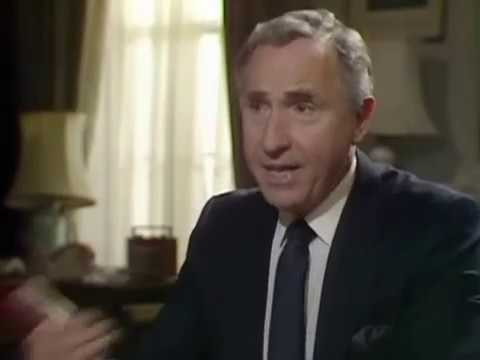

In [14]:
from IPython.display import YouTubeVideo

YouTubeVideo('MGlrE6oQ39o', width=800, height=600)

OK, all the jokes aside, to disprove this claim, we still need some hard evidents, which can be easily understand by the general public. In this project, I collected data of smoking rate and median income and median income on state level in recent 25 years. After that, I did correlation analysis of the two variables. 

### 2)	Importing Data
The smoking rate data were downloaded from CDC website (Save as one text file per year, totally 25 files):
https://nccd.cdc.gov/BRFSSPrevalence/rdPage.aspx?rdReport=DPH_BRFSS.ExploreByTopic&irbLocationType=StatesAndMMSA&islClass=CLASS17&islTopic=TOPIC55&islYear=20

The median income data were downloaded from Census Bureau website (Table H-8. Median Household Income by State, save as a csv file):
https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-income-households.html


### 3)	Cleaning Data
--clean up the data of smoking rate
--clean up the data of median income
--combine the two data sets

In [15]:
import os 
os.getcwd()

'C:\\Users\\_ZX_\\project\\project'

In [16]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import re

###First data cleaning step, clean up the data of smoking rate
#Show the original file format 
smoking_example=open("data/Smoker_Status/2019.txt", 'r')
print(*smoking_example.readlines(900)) #* symbol is use to print the list elements in a single line with space
smoking_example.close()
#Note: 4 lines make a unit in the text files
    #line1-State name
    #line2-Percent (%)
    #line3-95% CI
    #line4-n


2019
 Four Level Smoking Status (variable calculated from one or more BRFSS questions) (Crude Prevalence)
 View by: Overall
 Response: All
 Smoke everyday	Smoke some days	Former smoker	Never smoked
 All States, DC and Territories (median) **
 Percent (%)	11.1	4.7	25.2	58.8
 95% CI	not applicable	not applicable	not applicable	not applicable
 n	52	52	52	52
 All States and DC (median) **
 Percent (%)	11.1	4.7	25.2	58.6
 95% CI	not applicable	not applicable	not applicable	not applicable
 n	50	50	50	50
 Alabama
 Percent (%)	14.7	5.6	24.3	55.5
 95% CI	13.5 - 15.9	4.8 - 6.3	23.0 - 25.6	53.9 - 57.1
 n	817	341	1768	3818
 Alaska
 Percent (%)	12.1	5.3	25.9	56.8
 95% CI	10.1 - 14.1	4.1 - 6.6	23.4 - 28.3	53.9 - 59.7
 n	326	138	844	1541
 Arizona
 Percent (%)	9.5	5.5	26.4	58.7
 95% CI	8.3 - 10.6	4.6 - 6.4	24.9 - 27.9	56.9 - 60.5
 n	759	358	2657	4694
 Arkansas
 Percent (%)	14.4	5.8	25.5	54.3
 95% CI	12.9 - 15.9	4.8 - 6.8	23.9 - 27.2	52.3 - 56.3



In [17]:
# Read a text file and put smoking rate from a year into a datafram
def read_text_file(file_name):
    f=open(file_name, 'r')
    lines=f.readlines()
    f.close()
    
    # Remove asterisks(*), \n, and ' (median) '
    #https://www.geeksforgeeks.org/python-replace-substring-in-list-of-strings/
    lines = [sub.replace('*', '') for sub in lines]
    lines = [sub.replace('\n', '') for sub in lines]
    lines = [sub.replace(' (median) ', '') for sub in lines]
    
    #Get year and group information from the top of the file
    year = lines[0].strip()
    groups = lines[4].split("\t")
    groups.insert(0,"State")#match the length of table header with rows
    df = pd.DataFrame(columns = groups) # create an empty DataFrame with column names

    #Read percent values of each state into lists
    for x in range(2, int(len(lines)/4)+1): # 4 lines each uint; int(len(lines)/4+1 is the number of units
        percent = lines[x*4-2].split("\t") # split the line with percent values
        percent[0] = lines[x*4-3] #put state name at the 1st element of the list
        df.loc[len(df)] = percent # append percent (list) as a row to a Pandas df (DataFrame)
    df.iloc[0,0] = 'United States' #Replace "All States, DC and Territories"
    df['year'] = year
    df.set_index(['year','State'], inplace = True) #set multiindex
    print("Reading data for the year of {}".format(year)) # show progress during file reading
    
    return(df)



smoking_rate = pd.DataFrame() #create an empty DataFrame as the the summary dataFram
for i in range(1995,2020): # Read the text files for smoking rate into a dataFrame
    file_name = 'data/Smoker_Status/' + str(i) + '.txt' 
    df1 = read_text_file(file_name) # Return a new dataFrame for a year
    smoking_rate = smoking_rate.append(df1) #Append the new dataFrame at the end of the summary dataFrame
pd.options.display.max_rows = 1000
smoking_rate

Reading data for the year of 1995
Reading data for the year of 1996
Reading data for the year of 1997
Reading data for the year of 1998
Reading data for the year of 1999
Reading data for the year of 2000
Reading data for the year of 2001
Reading data for the year of 2002
Reading data for the year of 2003
Reading data for the year of 2004
Reading data for the year of 2005
Reading data for the year of 2006
Reading data for the year of 2007
Reading data for the year of 2008
Reading data for the year of 2009
Reading data for the year of 2010
Reading data for the year of 2011
Reading data for the year of 2012
Reading data for the year of 2013
Reading data for the year of 2014
Reading data for the year of 2015
Reading data for the year of 2016
Reading data for the year of 2017
Reading data for the year of 2018
Reading data for the year of 2019


Smoke everyday Smoke some days Former smoker Never smoked
year State                                                                  
1995 United States           19.9             2.6          25.3         51.7
     Alabama                 21.9             2.1          21.1         54.8
     Alaska                  22.3             2.6          27.2         47.9
     Arizona                 20.3             2.4          25.6         51.7
     Arkansas                22.7             2.3          23.5         51.5
...                           ...             ...           ...          ...
2019 West Virginia           18.3             5.4          26.4         49.9
     Wisconsin               10.8             4.5          26.8         57.8
     Wyoming                 14.2             4.2          24.4         57.2
     Guam                    16.2             7.2          17.2         59.5
     Puerto Rico              6.7             2.9          16.9         73.5

[1372 rows x 4 columns]

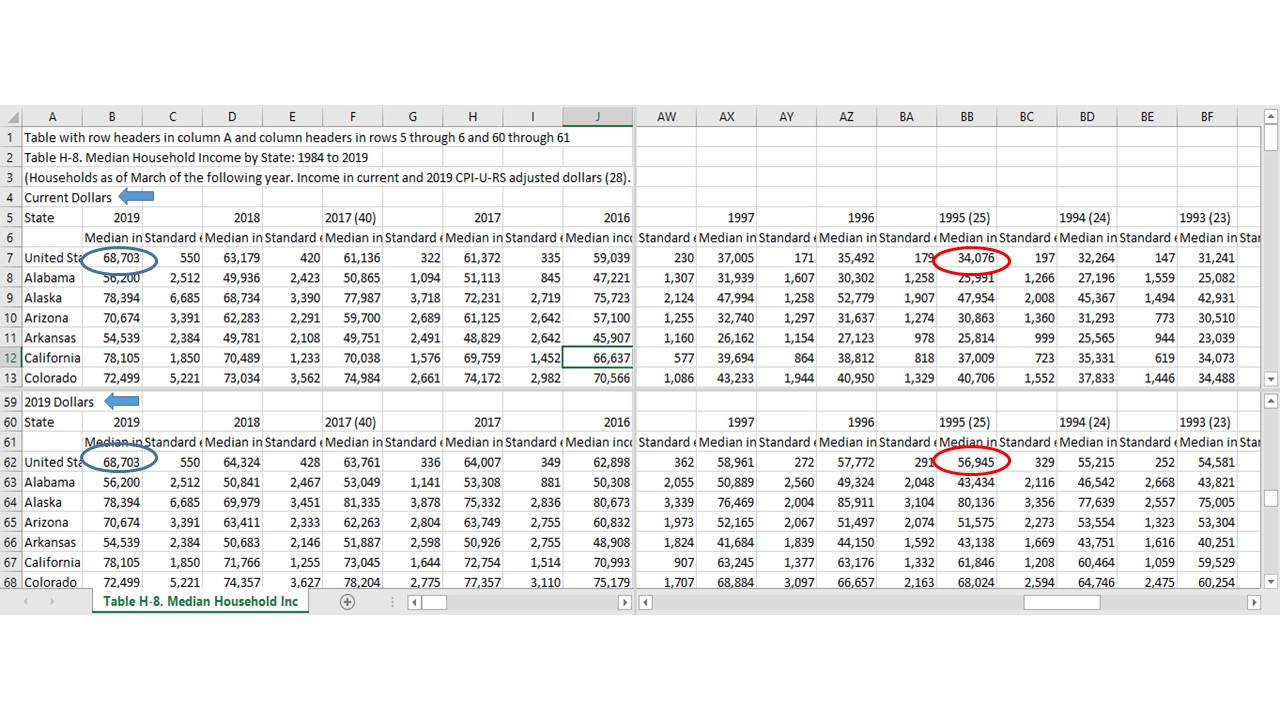

In [18]:
###Second data cleaning step: clean up the data of median income

#Show the original file format 
from IPython.display import Image
Image("data/Table H-8. Median Household Income by State_1984 to 2019.JPG")

# Notes:
    # The duplicated year tag should be eliminated
    # Years before 1995 should be excluded
    # 2019 dollars (not current dollars) should be used
    # 2 columns for each unit
        # Median income
        # Standard error


In [19]:
#Read the csv file with skip rows
median_income=pd.read_csv("data/Table H-8. Median Household Income by State_1984 to 2019.csv", 
                          header = 59, skiprows= [60,113,114], thousands=',')

#Select only the useful columns
median_income = median_income [['State', '2019', '2018', '2017 (40)', '2016', '2015', '2014',
                               '2013 (38)', '2012', '2011', '2010 (37)', '2009 (36)', '2008',
                               '2007', '2006', '2005', '2004 (revised)', '2003', '2002',
                               '2001', '2000 (30)', '1999 (29)', '1998', '1997', '1996', '1995 (25)']]
#Rename the columns
median_income.columns = ['State', '2019', '2018', '2017', '2016', '2015', '2014',
                               '2013', '2012', '2011', '2010', '2009', '2008',
                               '2007', '2006', '2005', '2004', '2003', '2002',
                               '2001', '2000', '1999', '1998', '1997', '1996', '1995']
#Reshape the data into a more computer-friendly form
#https://www.geeksforgeeks.org/python-pandas-melt/
median_income = pd.melt(median_income, id_vars =['State'], 
                        value_vars =['2019', '2018', '2017', '2016', '2015', '2014',
                               '2013', '2012', '2011', '2010', '2009', '2008',
                               '2007', '2006', '2005', '2004', '2003', '2002',
                               '2001', '2000', '1999', '1998', '1997', '1996', '1995']) 


median_income.columns = ['State', 'year', 'Median income'] #Rename columns
median_income.set_index(['year','State'], inplace = True) #set multiindex

median_income



Median income
year State                       
2019 United States          68703
     Alabama                56200
     Alaska                 78394
     Arizona                70674
     Arkansas               54539
...                           ...
1995 Virginia               60531
     Washington             59438
     West Virginia          41577
     Wisconsin              68440
     Wyoming                52688

[1300 rows x 1 columns]

In [20]:
###Third data cleaning step: combine the two data sets
#Check the two dataFrames by writing them into csv files
median_income.to_csv("median_income.csv")
smoking_rate.to_csv('smoking_rate.csv')

#Combine the two dataFrames by outer join
#https://pandas.pydata.org/docs/user_guide/merging.html
smoking_income = pd.concat([median_income, smoking_rate], join='outer',axis=1)

#Turn Pandas Multi-Index into column
#https://stackoverflow.com/questions/20110170/turn-pandas-multi-index-into-column
smoking_income.reset_index(inplace=True) 

#Check the combined dataFrames by writing it into a csv file
smoking_income.to_csv('smoking_income.csv')

#Note:
#District of Columbia, Puerto Rico, and other federal territories are mismatch in the two datasets

#Add a new column for States abbrevation: State, Districts & Territories to Two-Letter codes
us_state_abbrev = { #https://gist.github.com/rogerallen/1583593
    'United States':'US',
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}
#Use map() with the dictionary
#https://stackoverflow.com/questions/40814187/map-us-state-name-to-two-letter-acronyms-that-was-given-in-dictionary-separately/40814212
smoking_income['abbrev'] = smoking_income['State'].map(us_state_abbrev)
smoking_income['Median income'][1]

smoking_income

,year,State,Median income,Smoke everyday,Smoke some days,Former smoker,Never smoked,abbrev
0,1995,Alabama,43434.0,21.9,2.1,21.1,54.8,AL
1,1995,Alaska,80136.0,22.3,2.6,27.2,47.9,AK
2,1995,Arizona,51575.0,20.3,2.4,25.6,51.7,AZ
3,1995,Arkansas,43138.0,22.7,2.3,23.5,51.5,AR
4,1995,California,61846.0,12.7,2.5,28.2,56.7,CA
...,...,...,...,...,...,...,...,...
1370,2019,Virginia,81313.0,9.5,4.6,23.1,62.9,VA
1371,2019,Washington,82454.0,8.3,4.4,25.1,62.2,WA
1372,2019,West Virginia,53706.0,18.3,5.4,26.4,49.9,WV
1373,2019,Wisconsin,67355.0,10.8,4.5,26.8,57.8,WI


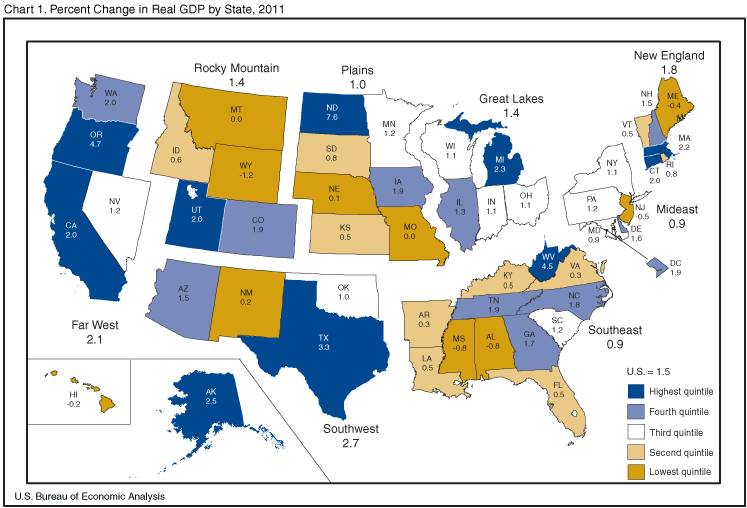

In [21]:
#Add a new column for regions (Bureau of Economic Analysis regions from wiki)
#https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States#Bureau_of_Economic_Analysis_regions
from IPython.display import Image
Image("data/BEA_regions.png")

In [22]:
# Dictionary of state vs. regions (50 states only)
US_Regions = { 
        'AK':'Far West',
        'AL':'Southeast',
        'AR':'Southeast',
        'AZ':'Southwest',
        'CA':'Far West',
        'CO':'Rocky Mountain',
        'CT':'New England',
        'DE':'Mideast',
        'FL':'Southeast',
        'GA':'Southeast',
        'HI':'Far West',
        'IA':'Plains',
        'ID':'Rocky Mountain',
        'IL':'Great Lakes', 
        'IN':'Great Lakes',
        'KS':'Plains',
        'KY':'Southeast',
        'LA':'Southeast',
        'MA':'New England',
        'MD':'Mideast',
        'ME':'New England',
        'MI':'Great Lakes',
        'MN':'Plains',
        'MO':'Plains',
        'MS':'Southeast',
        'MT':'Rocky Mountain',
        'NC':'Southeast',
        'ND':'Plains',
        'NE':'Plains',
        'NH':'New England',
        'NJ':'Mideast',
        'NM':'Southwest',
        'NV':'Far West',
        'NY':'Mideast',
        'OH':'Great Lakes',
        'OK':'Southwest',
        'OR':'Far West',
        'PA':'Mideast',
        'RI':'New England',
        'SC':'Southeast',
        'SD':'Plains',
        'TN':'Southeast',
        'TX':'Southwest',
        'UT':'Rocky Mountain',
        'VA':'Southeast',
        'VT':'New England',
        'WA':'Far West',
        'WI':'Great Lakes',
        'WV':'Southeast',
        'WY':'Rocky Mountain'
}
#Use map() with the dictionary
smoking_income['region'] = smoking_income['abbrev'].map(US_Regions)

#Convert smoking data to numeric type
smoking_income['Smoke everyday'] = pd.to_numeric(smoking_income['Smoke everyday'])
smoking_income['Smoke some days'] = pd.to_numeric(smoking_income['Smoke some days'])
smoking_income['Former smoker'] = pd.to_numeric(smoking_income['Former smoker'])
smoking_income['Never smoked'] = pd.to_numeric(smoking_income['Never smoked'])

#Check the combined dataFrames by writing it into a csv file
smoking_income.to_csv('smoking_income2.csv') 

#Drop the rows with region values as NaN--leave only the data from 50 states
#https://www.geeksforgeeks.org/how-to-drop-rows-in-dataframe-by-conditions-on-column-values/
index_names = smoking_income[smoking_income['region'].isnull()].index
smoking_income_state_only = smoking_income.drop(index_names) 
smoking_income_state_only 




,year,State,Median income,Smoke everyday,Smoke some days,Former smoker,Never smoked,abbrev,region
0,1995,Alabama,43434.0,21.9,2.1,21.1,54.8,AL,Southeast
1,1995,Alaska,80136.0,22.3,2.6,27.2,47.9,AK,Far West
2,1995,Arizona,51575.0,20.3,2.4,25.6,51.7,AZ,Southwest
3,1995,Arkansas,43138.0,22.7,2.3,23.5,51.5,AR,Southeast
4,1995,California,61846.0,12.7,2.5,28.2,56.7,CA,Far West
...,...,...,...,...,...,...,...,...,...
1370,2019,Virginia,81313.0,9.5,4.6,23.1,62.9,VA,Southeast
1371,2019,Washington,82454.0,8.3,4.4,25.1,62.2,WA,Far West
1372,2019,West Virginia,53706.0,18.3,5.4,26.4,49.9,WV,Southeast
1373,2019,Wisconsin,67355.0,10.8,4.5,26.8,57.8,WI,Great Lakes


### 4) Data Visualization

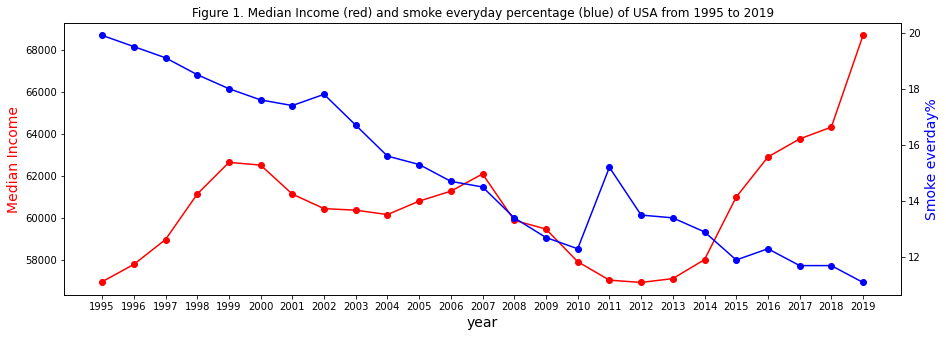

In [23]:
import matplotlib.pyplot as plt
import mplleaflet
import seaborn as sns
from sklearn.metrics import r2_score

#  One USA median income and smoke rate, two lines in one graphy with different y axis
#https://cmdlinetips.com/2019/10/how-to-make-a-plot-with-two-different-y-axis-in-python-with-matplotlib/

#Data Visualization step 1: plot the data for the whole country
Year = smoking_income[smoking_income['abbrev'] == 'US']['year'].tolist() 
Median_Income_USA = smoking_income[smoking_income['abbrev'] == 'US']['Median income'].tolist()
Smoke_everday_USA = smoking_income[smoking_income['abbrev'] == 'US']['Smoke everyday'].tolist()

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(15,5)) #https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots
# make a plot
ax.plot(Year, Median_Income_USA, color="red",marker="o")
#set title
plt.title('Figure 1. Median Income (red) and smoke everyday percentage (blue) of USA from 1995 to 2019')
# set x-axis label
ax.set_xlabel("year",fontsize=14)
# set y-axis label
ax.set_ylabel('Median Income',color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(Year, Smoke_everday_USA,color="blue",marker="o")

ax2.set_ylabel("Smoke everday%",color="blue",fontsize=14)
plt.show()

# save the plot as a file
fig.savefig('Figure 1. Median Income (red) and smoke everyday percentage (blue) of USA from 1995 to 2019.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

#### Based on the above graphy, we can find a reverse trend between the median income and smoking rate (smoke everyday percentage) in the recent 25 year. For example, when median income is on low level at ~ 1995, ~2002, and ~2011, smoking rate is on relatively higher level. This result is in the national level. What about the state level?

Figure 2. Correlation between smoking rate and median income at 1995 and 2019


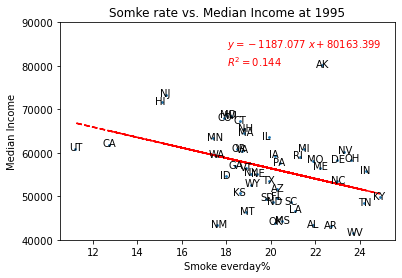

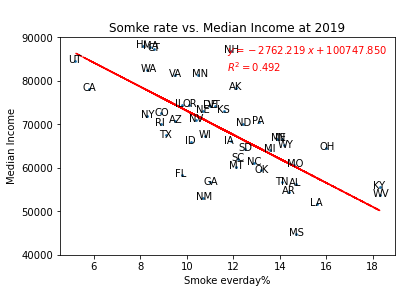

In [34]:
#Data Visualization step 2: Scatter plots with state data with trend line
#https://stackoverflow.com/questions/41635448/how-can-i-draw-scatter-trend-line-on-matplot-python-pandas
#https://matplotlib.org/stable/gallery/subplots_axes_and_figures/axes_margins.html#sphx-glr-gallery-subplots-axes-and-figures-axes-margins-py


print('Figure 2. Correlation between smoking rate and median income at 1995 and 2019')


# Scatter plot of 1995 state level data
#define x, y, and annotations (labeling of the point)
Median_Income_1995 = smoking_income_state_only[smoking_income_state_only['year'] == '1995']['Median income'].tolist()
Smoke_everday_1995 = smoking_income_state_only[smoking_income_state_only['year'] == '1995']['Smoke everyday'].tolist()
State_Abbrev_1995 = smoking_income_state_only[smoking_income_state_only['year'] == '1995']['abbrev'].tolist()
y = Median_Income_1995
x= Smoke_everday_1995
annotations = State_Abbrev_1995

#Delete nan: make a mask for missing values, then apply it on an array
#https://stackoverflow.com/questions/32192163/python-and-operator-on-two-boolean-lists-how
mask = (~np.isnan(x)) &  (~np.isnan(y)) 
y = np.array(y)[mask].tolist()
x = np.array(x)[mask].tolist()
annotations = np.array(annotations)[mask].tolist()

#scatter plot
plt.ylim([40000, 90000])
plt.scatter(x, y, s=3)

#label the data point using abbrevation of state name (annotation)
#https://www.delftstack.com/howto/matplotlib/matplotlib-label-scatter-plot-points/
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i]-0.29, y[i]-415))

#trend line
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

#equation and R^2
y_hat = np.poly1d(z)(x)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.5, 0.93, text,transform=plt.gca().transAxes,
     fontsize=10, verticalalignment='top', color='red')

#title and axis

plt.title('Somke rate vs. Median Income at 1995')
plt.xlabel('Smoke everday%')
plt.ylabel('Median Income')
plt.show()




# Scatter plot of 2019 state level data
#define x, y, and annotations (labeling of the point)
Median_Income_2019 = smoking_income_state_only[smoking_income_state_only['year'] == '2019']['Median income'].tolist()
Smoke_everday_2019 = smoking_income_state_only[smoking_income_state_only['year'] == '2019']['Smoke everyday'].tolist()
State_Abbrev_2019 = smoking_income_state_only[smoking_income_state_only['year'] == '2019']['abbrev'].tolist()
y = Median_Income_2019
x= Smoke_everday_2019
annotations = State_Abbrev_2019

#Delete nan: make a mask for missing values, then apply it on an array
#https://stackoverflow.com/questions/32192163/python-and-operator-on-two-boolean-lists-how
mask = (~np.isnan(x)) &  (~np.isnan(y)) 
y = np.array(y)[mask].tolist()
x = np.array(x)[mask].tolist()
annotations = np.array(annotations)[mask].tolist()

#scatter plot
plt.ylim([40000, 90000])
plt.scatter(x, y, s=3)

#label the data point using abbrevation of state name (annotation)
#https://www.delftstack.com/howto/matplotlib/matplotlib-label-scatter-plot-points/
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i]-0.29, y[i]-415))

#trend line
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")


#equation and R^2
y_hat = np.poly1d(z)(x)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.5, 0.97, text,transform=plt.gca().transAxes,
     fontsize=10, verticalalignment='top', color='red')

#title and axis
plt.title('Somke rate vs. Median Income at 2019')
plt.xlabel('Smoke everday%')
plt.ylabel('Median Income')

plt.show()



#### From the above scatter plots, we can find the following facts:
    (1) The Correlation coefficient (R) and regression coefficient (β, slope) are in negative values, which indicates the median income decreases when smoking rate increases    
    (2) The absolute values of R and β are higher in 2019 than 1995, which indicates the negative association getting stronger and more significant.
    (3) The change probably can be attributed to the data from states like AK (Alaska) and UT (Utah). KY (Kentucky) is not in good position in both 1995 and 2019  

So we know the situation at the beginning and end points of the recent 25 years. But how does it happened in between? Let us plot data points from all years.

Figure 3. Correlation coefficient (R) and regression coefficient (β) between smoking rate and median income from 1995 to 2019


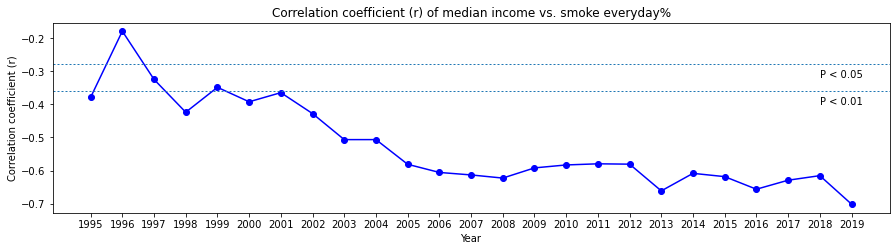

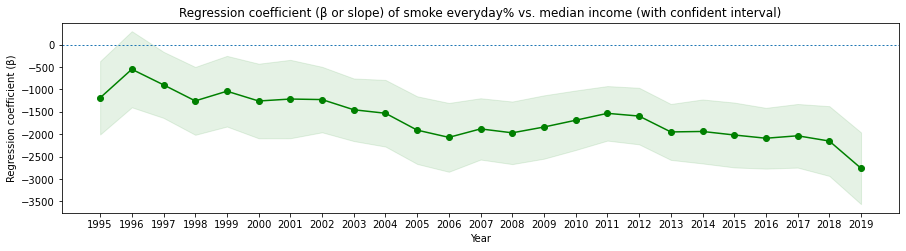

In [25]:

print ('Figure 3. Correlation coefficient (R) and regression coefficient (β) between smoking rate and median income from 1995 to 2019')

#line plot -- Correlation coefficient (r) vs. year


correlation = pd.DataFrame( columns=['year','R_value']) #create an empty DataFrame for correlation between smoking and income
for i in range(1995,2020): # loop through years
    year = str(i)
    smoking = smoking_income_state_only[smoking_income_state_only['year'] == year]['Smoke everyday']
    income = smoking_income_state_only[smoking_income_state_only['year'] == year]['Median income']
    R_value = smoking.corr(income)
    df1 = pd.DataFrame([[year,R_value]], columns=['year','R_value'])
    correlation = correlation.append(df1)

x = correlation['year']
y = correlation['R_value']
# line plot
plt.figure(figsize=(15, 3.5))#figure size: https://stackabuse.com/change-figure-size-in-matplotlib/
plt.plot(x, y, color="blue",marker="o")
plt.title('Correlation coefficient (r) of median income vs. smoke everyday%')
plt.xlabel('Year')
plt.ylabel('Correlation coefficient (r)')


# Add reference lines with R critial values (N = 50, p =0.05 or 0.01)  
# https://sites.google.com/site/abramenkosscience/lab-work/statistics/correlation-simple-pearson
#https://queirozf.com/entries/add-labels-and-text-to-matplotlib-plots-annotation-examples
R_at_P005 = -0.279 # R value @ p = 0.05
R_at_P001 = -0.361 # R value @ p = 0.01
plt.axhline(y=R_at_P005, lw=1,dashes=[2, 2])
plt.axhline(y=R_at_P001, lw=1,dashes=[2, 2])
plt.text(23,-0.32,'P < 0.05')
plt.text(23,-0.4,'P < 0.01')
plt.show()


#line plot -- regression coefficient (beta, β) vs. year
#Equation for beta confident interval calculation: http://www.stat.wmich.edu/naranjo/stat1600/p119.pdf
    # CI (confident interval of beta) ~ mean +/- 1.96 * SE

regression = pd.DataFrame( columns=['year','beta','CI']) #create an empty DataFrame for correlation between smoking and income
for i in range(1995,2020): # loop through years
    year = str(i)
    x = smoking_income_state_only[smoking_income_state_only['year'] == year]['Smoke everyday']
    y = smoking_income_state_only[smoking_income_state_only['year'] == year]['Median income']
    
    #Delete nan: make a mask for missing values, then apply it on an array
    #https://stackoverflow.com/questions/32192163/python-and-operator-on-two-boolean-lists-how
    mask = (~np.isnan(x)) &  (~np.isnan(y)) 
    y = np.array(y)[mask]
    x = np.array(x)[mask]
    
    #Regression 
    #https://stackoverflow.com/questions/36400419/how-to-calculate-the-99-confidence-interval-for-the-slope-in-a-linear-regressio
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y) #use scipy's linear regression
    df1 = pd.DataFrame([[year,slope, 1.96*std_err]], columns=['year','beta','CI'])
    regression = regression.append(df1)

#Plot a Confidence Interval in Python
#https://www.statology.org/plot-confidence-interval-python/

regression


x = regression['year']
y = regression['beta']
ci = regression['CI']


# line plot
#https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python
plt.figure(figsize=(15, 3.5))#figure size: https://stackabuse.com/change-figure-size-in-matplotlib/
plt.plot(x, y, color="g",marker="o")
plt.title('Regression coefficient (β or slope) of smoke everyday% vs. median income (with confident interval)')
plt.xlabel('Year')
plt.ylabel('Regression coefficient (β)')
plt.fill_between(x, (y-ci), (y+ci), color='g', alpha=.1)
plt.axhline(y=0, lw=1,dashes=[2, 2])
plt.show()


#### We can see that the two curves basically parallel to each other. Both of them showed higher values at 1995-1996, and lower values at 2019. After the decreasing phase at 1996 to 2006, the curves “plateau” around 2006-2018, and going down again at 2019. Among all 25 years, 1996 is the only year with insignificant R or β values (p>0.05) 

https://conjointly.com/kb/regression-discontinuity-analysis/

country-city ratio?